# MNIST CNN Based Classifier

Based on this competition: https://www.kaggle.com/c/digit-recognizer/overview

In this notebook, we'll build - and train - a simple CNN to detect the MNIST digits with a 0.99978 accuracy on the testing set. This notebook is currently in 52nd place on the leaderboard.

## Python Set-up

We'll import what we need in order to create an effective CNN model into Python, as well as some libraries that help preprocess the data, or augment it.

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential
import csv
from IPython.display import clear_output

You can comment out this section if you're not using a GPU.

In [20]:
print(tf.config.list_physical_devices('GPU'))
assert tf.test.is_built_with_cuda()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Set the parent directory for the data which you can download from Kaggle.com

In [21]:
data_path = './data'

## Data Preprocessing

Here, we intake the data and transform it into something more usable!

### MNIST Dataset

A simple load and reshape is all we need to grab the data from the train.csv!

In [22]:
train = pd.read_csv(data_path + '/train.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
y_m_train = train['label'].values
X_m_train = train.drop(['label'], axis=1)

In [24]:
X_m_train = X_m_train.values.reshape(-1, 28, 28, 1)

Note that we're stratifying the training/test split. This is to ensure that we have consitent proportional representation of the classes through out our training/test set.

In [25]:
X_m_train, X_valid, y_m_train, y_valid = train_test_split(X_m_train, y_m_train, test_size=0.2, random_state=42, stratify=y_m_train)

### QMNIST Preprocessing

I've elected to augment the MNIST dataset with the QMNIST dataset to enable us to reach for higher accuracy.

You can find the dataset as well as information on how to use it here: https://www.kaggle.com/fedesoriano/qmnist-the-extended-mnist-dataset-120k-images?select=MNIST-120k

In [39]:
import pickle
def de_pickler(pickle_path):
    with open(pickle_path, 'rb') as f:
        return pickle.load(f)

pickle_path = './data/MNIST-120k'
qmnist = de_pickler(pickle_path)

q_data = qmnist['data']
q_labels = qmnist['labels']
print(q_data.shape, q_labels.shape)

(120000, 28, 28) (120000, 1)


In [27]:
X_q_train = np.expand_dims(q_data, axis=-1)
y_q_train = np.squeeze(q_labels)

### Merging MNIST and QMNIST

We ensure our datasets are the same shape and then concatenate/scale them.

In [28]:
print(X_q_train.shape, y_q_train.shape)
print(X_m_train.shape, y_m_train.shape)

(120000, 28, 28, 1) (120000,)
(33600, 28, 28, 1) (33600,)


In [29]:
X_train = np.concatenate((X_m_train, X_q_train), axis=0)

X_train = X_train / 255.0
X_valid = X_valid / 255.0

Note: It's important to cast the labels to their cateogorical forms so we can train!

In [30]:
y_train = np.concatenate((y_m_train, y_q_train), axis=0)

y_train = keras.utils.to_categorical(y_train, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)

## Data Augmentation

The only data augmentation we're doing (other than including the QMNIST dataset) is a simple ImageDataGenerator.

In [31]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1)

datagen.fit(X_train)

iterator = datagen.flow(X_train, y_train, batch_size=64)

## Model Building and Training

We build a simple CNN using some default values and adding a few Batch Normalization layers to reduce potential overfitting. The Batch Normalization layers really help to generalize the model, given the amount we're training on it.

In [32]:

cnn_model = Sequential([
    Conv2D(64, 3, padding='same', activation='relu', input_shape=X_train[0].shape),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(),
    Flatten(),
    Dense(512, 'relu'),
    Dense(256, 'relu'),
    Dense(10, 'softmax')
])

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)             

We compile the model using a robust optimization algorithm and a well suited loss function.

We add a callback for early-stopping to prevent training more than is necessary, any compute saved is time/money saved. In addition, we can set our training to a default of 100 epochs and feel safe that we won't overtrain and wind up overfitting/need to tune our epoch hyper-parameter.

Note: This model takes about 35min. to train.

In [33]:
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)

cnn_history = cnn_model.fit(iterator, epochs=100,
                            validation_data=(X_valid, y_valid),
                            callbacks=[early_stopping],
                            verbose=2)

clear_output()

## Output and Visualization

Now we can view our models history and see some insights:

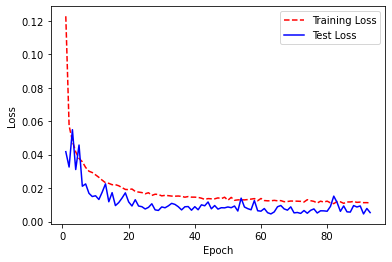

In [40]:
import matplotlib.pyplot as plt

# Get training and test loss histories
training_loss = cnn_history.history['loss']
test_loss = cnn_history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

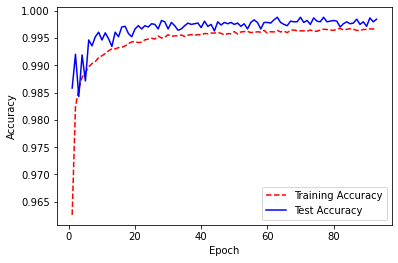

In [42]:
# Get training and test accuracy histories
training_accuracy = cnn_history.history['accuracy']
test_accuracy = cnn_history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize accuracy history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

From the above graphs, we can see that our training leveled off pretty well after the ~40th epoch. Our loss/accuracy validation loss/accuracy seems fairly inline with a decent model. There doesn't appear to be much overfitting or underfitting. The model could likely be training longer without overfitting, but the gains in accuracy would be extremely diminshed. 

Below, we will create/plot the confusion matrix to get some more insight into how our model is performing!

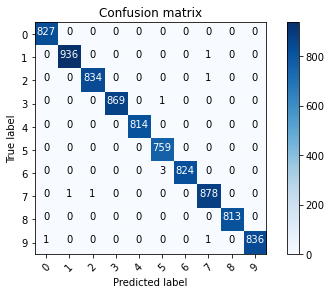

In [43]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = cnn_model.predict(X_valid)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_valid ,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

From the confusion matrix we can see that the model is performingly extremely well. There is very little overall confusion, save one area: 5s. It looks like the model is having a tiny bit of trouble with 6/5. 

Let's peek into the errors and see if we can learn anything else!

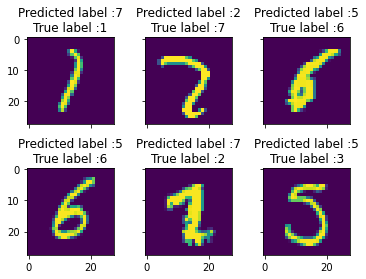

In [51]:
# Errors are difference between predicted labels and true labels
errors = (y_pred_classes - y_true != 0)

y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
X_val_errors = X_valid[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    fig.subplots_adjust(hspace=0.5)
    plt.show()

# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_delta_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, y_pred_classes_errors, y_true_errors)

For the most part, these errors look completely reasonable. Even to my eyes, I have some difficulty correctly classifying these examples! Except, of course, for the 5s! For some reason, the model is predicting numbers that look (to my eyes) a lot like 6s, as 5s. This seems like something that could be looked into more indepth!

## Making/Submitting Predictions

Following a similar process to above, we predict the test data and convert it to the format required by Kaggle and submit it!

In [34]:
test = pd.read_csv(data_path + './test.csv')
test = test.values.reshape(-1, 28, 28, 1)
test = test / 255.0

In [35]:
submission_predictions = cnn_model.predict(test)

In [36]:
submission_predictions = np.argmax(submission_predictions, axis = 1)

In [37]:
print(submission_predictions)

[2 0 9 ... 3 9 2]


In [38]:
with open('./submission_qmnist.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    spamwriter.writerow(['ImageId', 'Label'])
    for i, item in enumerate(submission_predictions):
      spamwriter.writerow([i+1, item])